In [1]:
!pip install sumy parsel pycountry tensorflow_hub nltk transformers tensorflow gensim

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 15.8 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21695 sha256=2537b655c20bdbdb6c142f9bf5dc750043dde4aad6159d81b4438646dd93c03d
  Stored in directory: /root/.cache/pip/wheels/32/99/64/59305409cacd03aa03e7bddf31a9db34b1fa7033bd41972662
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=4999edc4e674499886393e72dfce2dbebb3bb6f950e0ba9a84864e334accb618
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built breadability docopt


In [2]:
import gc
import pandas as pd
from transformers import pipeline
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from tqdm import tqdm
from parsel import Selector
import time
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow_hub as hub
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import pycountry
import string
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models, callbacks

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# 1. Data Collection

In [3]:
!git clone -n --depth=1 --filter=tree:0 \
  https://github.com/CoronaNetDataScience/corona_tscs

!cd corona_tscs && git sparse-checkout set --no-cone /data/CoronaNet/data_country/coronanet_release && git checkout

Cloning into 'corona_tscs'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1 (delta 0), reused 1 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (1/1), done.
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 0), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 19.90 KiB | 333.00 KiB/s, done.
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 201 (delta 37), reused 1 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (201/201), 27.02 MiB | 2.12 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (201/201), done.
Your branch is up to date with 'origin/master'.


In [4]:
dfs = []
for csv in os.listdir('corona_tscs/data/CoronaNet/data_country/coronanet_release'):
    # read each csv into a separate dataframe
    df = pd.read_csv(os.path.join('corona_tscs/data/CoronaNet/data_country/coronanet_release', csv), low_memory=False)
    dfs.append(df)

big_frame = pd.concat(dfs, ignore_index=True)

In [5]:
big_frame.shape

(200486, 68)

In [6]:
big_frame.columns

Index(['record_id', 'policy_id', 'entry_type', 'update_type', 'update_level',
       'update_level_var', 'description', 'date_announced', 'date_start',
       'date_end', 'date_end_spec', 'country', 'ISO_A3', 'ISO_A2',
       'init_country_level', 'domestic_policy', 'province', 'ISO_L2', 'city',
       'type', 'type_sub_cat', 'type_new_admin_coop', 'type_vac_cat',
       'type_vac_mix', 'type_vac_reg', 'type_vac_purchase', 'type_vac_group',
       'type_vac_group_rank', 'type_vac_who_pays', 'type_vac_dist_admin',
       'type_vac_loc', 'type_vac_cost_num', 'type_vac_cost_scale',
       'type_vac_cost_unit', 'type_vac_cost_gov_perc', 'type_vac_amt_num',
       'type_vac_amt_scale', 'type_vac_amt_unit', 'type_vac_amt_gov_perc',
       'type_text', 'institution_cat', 'institution_status',
       'institution_conditions', 'target_init_same', 'target_country',
       'target_geog_level', 'target_region', 'target_province', 'target_city',
       'target_intl_org', 'target_other', 'target_who

In [7]:
big_frame.head(10)
big_frame['entry_type']

,entry_type
0,new_entry
1,new_entry
2,new_entry
3,new_entry
4,new_entry
...,...
200481,new_entry
200482,new_entry
200483,new_entry
200484,new_entry


In [8]:
gc.collect()

del(dfs)

In [9]:
df = big_frame[["description", "type"]].drop_duplicates(subset=['description']).reset_index(drop=True)

In [10]:
df

,description,type
0,"September 14, 2020: With Bulletin N. 262, the ...","New Task Force, Bureau or Administrative Confi..."
1,"On April 7, New Zealand government announced t...","New Task Force, Bureau or Administrative Confi..."
2,"February 25, 2020: With Bulletin N. 90, the It...","New Task Force, Bureau or Administrative Confi..."
3,"March 11, 2020: With Bulletin N. 107, the Ital...","New Task Force, Bureau or Administrative Confi..."
4,"December 15, 2020: With Bulletin N. 317, the I...","New Task Force, Bureau or Administrative Confi..."
...,...,...
118886,"On December 23th, Morocco prohibits all public...",Restrictions of Mass Gatherings
118887,"On May 11th, the Habous and Islamic Affairs mi...",Restrictions of Mass Gatherings
118888,"As of March 20th, Morocco is requiring all to ...",Social Distancing
118889,"On April 7th 2020, Moroccan authorities make m...",Social Distancing


In [11]:
df['type'].value_counts()

,count
type,
Restriction and Regulation of Businesses,17092
External Border Restrictions,11983
Restrictions of Mass Gatherings,10313
Health Resources,9352
Social Distancing,8675
Closure and Regulation of Schools,8351
Lockdown,7303
Quarantine,7049
Restriction and Regulation of Government Services,6212


## 2. Preprocess Data

In [12]:
# Combine all preprocessing steps
def preprocess_text(text):

    # 1. Convert text to lowercase
    def to_lower(text):
        return text.lower()

    # 2. Remove punctuation and numbers
    def remove_punctuation_numbers(text):
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\b(\d+)(st|nd|rd|th)\b', '', text)  # Remove Ordered Numbering
        return text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # 3. Tokenize text into words
    def tokenize(text):
        return nltk.word_tokenize(text)

    # 4. Remove stopwords (common words with little meaning)
    stop_words = list(stopwords.words('english'))
    def remove_stopwords(tokens):
        for c in pycountry.countries:
            if c.name.lower() in tokens:
                tokens = re.sub(c.name.lower(), '', text)
        return [word for word in tokens if word not in stop_words]

    # 5. Apply lemmatization to reduce words to their base (dictionary) form
    lemmatizer = WordNetLemmatizer()
    def apply_lemmatization(tokens):
        return [lemmatizer.lemmatize(word) for word in tokens]

    text = to_lower(text)
    text = remove_punctuation_numbers(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = apply_lemmatization(tokens)
    return " ".join(tokens)

# 6- Apply Preprocessing
df["description_processed"] = df["description"].apply(preprocess_text)

In [13]:
# stop_words = list(stopwords.words('english'))
#
# # include country names in stopwords
# country_text = []
# for text in df["description_processed"].tolist():
#     for c in pycountry.countries:
#         if c.name.lower() in text:
#             text = re.sub(c.name.lower(), '', text)
#     country_text.append(text)
#
# df["description_2"] = country_text
#
# for stop_word in stop_words:
#     regex_stopword = r"\b" + stop_word + r"\b"
#     df['description_processed'] = df['description_processed'].str.replace(regex_stopword, '')

In [14]:
df

,description,type,description_processed
0,"September 14, 2020: With Bulletin N. 262, the ...","New Task Force, Bureau or Administrative Confi...",september bulletin n italian ministry health a...
1,"On April 7, New Zealand government announced t...","New Task Force, Bureau or Administrative Confi...",april new zealand government announced country...
2,"February 25, 2020: With Bulletin N. 90, the It...","New Task Force, Bureau or Administrative Confi...",f e b r u r w h b u l l e n n h ...
3,"March 11, 2020: With Bulletin N. 107, the Ital...","New Task Force, Bureau or Administrative Confi...",r c h w h b u l l e n n h e l ...
4,"December 15, 2020: With Bulletin N. 317, the I...","New Task Force, Bureau or Administrative Confi...",e c e b e r w h b u l l e n n h ...
...,...,...,...
118886,"On December 23th, Morocco prohibits all public...",Restrictions of Mass Gatherings,n e c e b e r h p r h b l l p u b ...
118887,"On May 11th, the Habous and Islamic Affairs mi...",Restrictions of Mass Gatherings,may th habous islamic affair ministry announes...
118888,"As of March 20th, Morocco is requiring all to ...",Social Distancing,f r c h h r e q u r n g l l ...
118889,"On April 7th 2020, Moroccan authorities make m...",Social Distancing,april th moroccan authority make mask wearing ...


In [15]:
list_columns = ["description_processed", "type"]
df2 = df[list_columns]

df2 = df2.rename(columns={'description_processed': 'description'})

# Modelling

#### Label encoding

In [16]:
category_codes = {
    'Anti-Disinformation Measures': 0,
    'Hygiene': 1,
    'Curfew': 2,
    'Closure and Regulation of Schools': 3,
    'Declaration of Emergency': 4,
    'External Border Restrictions': 5,
    'Health Monitoring': 6,
    'Health Resources': 7,
    'Health Testing': 8,
    'Internal Border Restrictions': 9,
    'Lockdown': 10,
    'New Task Force, Bureau or Administrative Configuration': 11,
    'COVID-19 Vaccines': 12,
    'Public Awareness Measures': 13,
    'Quarantine': 14,
    'Restriction and Regulation of Businesses': 15,
    'Restriction and Regulation of Government Services': 16,
    'Restrictions of Mass Gatherings': 17,
    'Social Distancing': 18
}

# Category mapping
df2['type_code'] = df2['type']
df2 = df2.replace({'type_code':category_codes})

df2.head()

,description,type,type_code
0,september bulletin n italian ministry health a...,"New Task Force, Bureau or Administrative Confi...",11
1,april new zealand government announced country...,"New Task Force, Bureau or Administrative Confi...",11
2,f e b r u r w h b u l l e n n h ...,"New Task Force, Bureau or Administrative Confi...",11
3,r c h w h b u l l e n n h e l ...,"New Task Force, Bureau or Administrative Confi...",11
4,e c e b e r w h b u l l e n n h ...,"New Task Force, Bureau or Administrative Confi...",11


#### Split train-test sets

In [17]:
df2

,description,type,type_code
0,september bulletin n italian ministry health a...,"New Task Force, Bureau or Administrative Confi...",11
1,april new zealand government announced country...,"New Task Force, Bureau or Administrative Confi...",11
2,f e b r u r w h b u l l e n n h ...,"New Task Force, Bureau or Administrative Confi...",11
3,r c h w h b u l l e n n h e l ...,"New Task Force, Bureau or Administrative Confi...",11
4,e c e b e r w h b u l l e n n h ...,"New Task Force, Bureau or Administrative Confi...",11
...,...,...,...
118886,n e c e b e r h p r h b l l p u b ...,Restrictions of Mass Gatherings,17
118887,may th habous islamic affair ministry announes...,Restrictions of Mass Gatherings,17
118888,f r c h h r e q u r n g l l ...,Social Distancing,18
118889,april th moroccan authority make mask wearing ...,Social Distancing,18


In [18]:
df = big_frame[["description", "type"]].dropna()
df = df.drop_duplicates(subset=["description"])#--->Prevents data leakage and ensures model isn't trained multiple times on the same input with possibly conflicting labels.

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['type'])
X_train, X_test, y_train, y_test = train_test_split(
    df['description'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)


>why we chose this model?

Takes raw English text (sentences or paragraphs) and Outputs a 128-dimensional dense vector representing and capturing semantic meaning, better than simple methods like Bag-of-Words or TF-IDF

In [19]:
import numpy as np
import gensim.downloader as api

glove_model = api.load("glove-wiki-gigaword-100")

def glove_embed(text_list, model):
    """
    Takes a list of text strings and returns a matrix of averaged word vectors.
    Shape: (num_samples, embedding_dim)
    """
    encoded_data = []

    for text in text_list:
        # A. Basic Tokenization
        # (Split by space and lowercase. For better results, use NLTK or Spacy here)
        words = str(text).lower().split()

        # B. Filter for words present in GloVe vocabulary
        vectors = [model[word] for word in words if word in model]

        # C. Aggregation (Averaging)
        if len(vectors) == 0:
            # Handle case where article has no known words (returns zeros)
            avg_vector = np.zeros(model.vector_size)
        else:
            # Average all word vectors to get one "Article Vector"
            avg_vector = np.mean(vectors, axis=0)

        encoded_data.append(avg_vector)

    return np.array(encoded_data)

X_train_embed = glove_embed(X_train.tolist(), glove_model)
X_test_embed = glove_embed(X_test.tolist(), glove_model)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [32]:
# Build a tuned model
model = models.Sequential([
    layers.Input(shape=(100,), dtype=tf.float32),

    # First dense block
    layers.Dense(256, activation='relu'),

    # Second dense block
    layers.Dense(128, activation='relu'),

    # Third dense block
    layers.Dense(64, activation='relu'),

    # Fourth dense block
    layers.Dense(32, activation='relu'),

    # Output layer
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile with a lower initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1
)


history = model.fit(
    X_train_embed, y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/60
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4150 - loss: 1.9356 - val_accuracy: 0.5839 - val_loss: 1.3736 - learning_rate: 0.0010
Epoch 2/60
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.5997 - loss: 1.3319 - val_accuracy: 0.6104 - val_loss: 1.2825 - learning_rate: 0.0010
Epoch 3/60
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6283 - loss: 1.2273 - val_accuracy: 0.6268 - val_loss: 1.2377 - learning_rate: 0.0010
Epoch 4/60
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6481 - loss: 1.1648 - val_accuracy: 0.6403 - val_loss: 1.1985 - learning_rate: 0.0010
Epoch 5/60
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6580 - loss: 1.1313 - val_accuracy: 0.6492 - val_loss: 1.1681 - learning_rate: 0.0010
Epoch 6/60
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6687 - loss: 1.0865 - val_accuracy: 0.6533 - val_loss: 1.1508 - learning_rate: 0.0010
Epoch 7/60
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.67

> What did we do ?
1. **Handling Complex Patterns**
  Text data is rich and nuanced. The dense layers model complex interactions that simpler models (e.g., logistic regression) may miss.
2. **usage of Strong Embeddings**
  we aare using NNLM embeddings from TensorFlow Hub, which are pretrained on massive corpora (e.g., Google News).
  These embeddings capture semantic meaning of words and phrases, not just surface patterns.
3. **End-to-End Learnable**
  The model fine-tunes the abstraction layers to optimize classification accuracy directly from high-level representations.
4. **Scalable and Fast to Train**
  Thanks to embeddings, the input dimensionality is fixed (128), so the network is lightweight, fast, and doesn't need tokenization or padding like transformers.
5. **Well-Regularized**
  The use of Dropout and BatchNorm prevents overfitting and stabilizes training.


# Evaluation

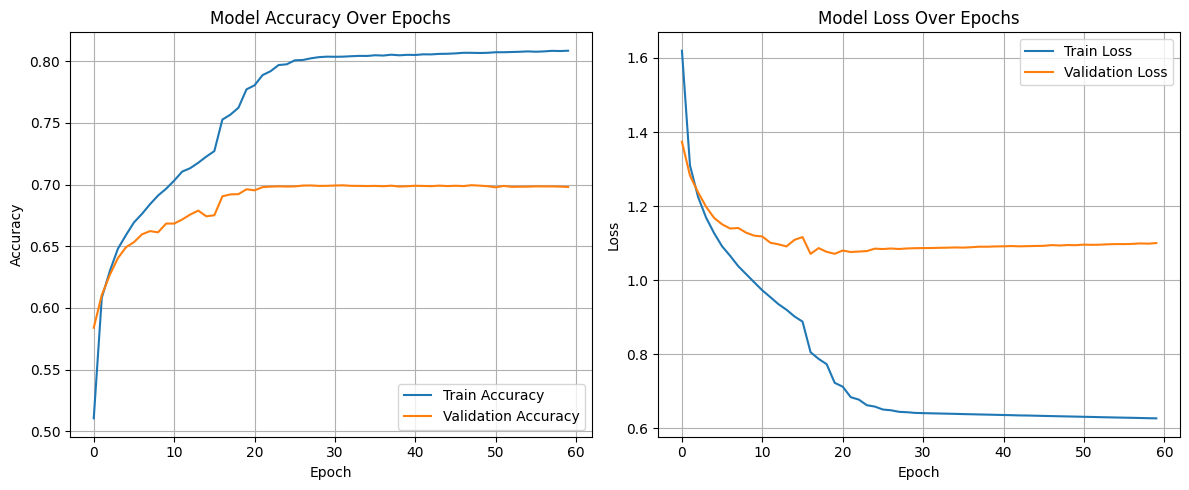

In [33]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [34]:
y_pred = model.predict(X_test_embed)
y_pred_labels = tf.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
                                                        precision    recall  f1-score   support

                          Anti-Disinformation Measures       0.57      0.46      0.51       105
                                     COVID-19 Vaccines       0.81      0.81      0.81       787
                     Closure and Regulation of Schools       0.82      0.88      0.85      1670
                                                Curfew       0.83      0.80      0.82       564
                              Declaration of Emergency       0.88      0.88      0.88       678
                          External Border Restrictions       0.76      0.81      0.79      2397
                                     Health Monitoring       0.43      0.39      0.41       491
                                      Health Resources       0.70      0.70      0.70      1870
                                        Health Testing       0.55      0.54      0.55       62